## Aircraft Engine Failure Prediction

This file includes steps to build a LSTM Model. Since any deep learning models require many hyperparameters, finding out the perfect architecture is very important. While there is no specific method for model architecture, We can rely on some rule of thumbs.

I follow tips suggested in this article: https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
# os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

15

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print Results

In [22]:
def print_results(y_test, y_pred):
    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Model with 1 hidden layer

#### Model 1

In [23]:
history = History()

model1 = Sequential()
model1.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
# fit the model
model1.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history])

Epoch 1/100
222/222 [==============================] - 8s 25ms/step - loss: 0.2404 - accuracy: 0.8448 - val_loss: 0.3559 - val_accuracy: 0.8869
Epoch 2/100
222/222 [==============================] - 4s 20ms/step - loss: 0.1502 - accuracy: 0.8885 - val_loss: 0.2979 - val_accuracy: 0.8844
Epoch 3/100
222/222 [==============================] - 4s 20ms/step - loss: 0.1190 - accuracy: 0.9007 - val_loss: 0.2745 - val_accuracy: 0.8882
Epoch 4/100
222/222 [==============================] - 4s 20ms/step - loss: 0.1034 - accuracy: 0.9110 - val_loss: 0.2513 - val_accuracy: 0.9034
Epoch 5/100
222/222 [==============================] - 4s 20ms/step - loss: 0.0933 - accuracy: 0.9243 - val_loss: 0.2241 - val_accuracy: 0.9155
Epoch 6/100
222/222 [==============================] - 4s 20ms/step - loss: 0.0782 - accuracy: 0.9401 - val_loss: 0.2142 - val_accuracy: 0.9225
Epoch 7/100
222/222 [==============================] - 4s 19ms/step - loss: 0.0749 - accuracy: 0.9410 - val_loss: 0.1835 - val_accuracy:

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Loss')

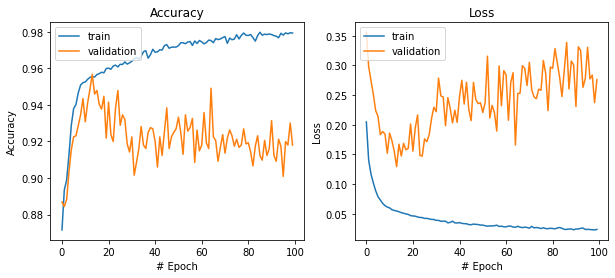

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 Score:  0.9666666666666667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        70
           1       0.97      0.97      0.97        30

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9761904761904763 



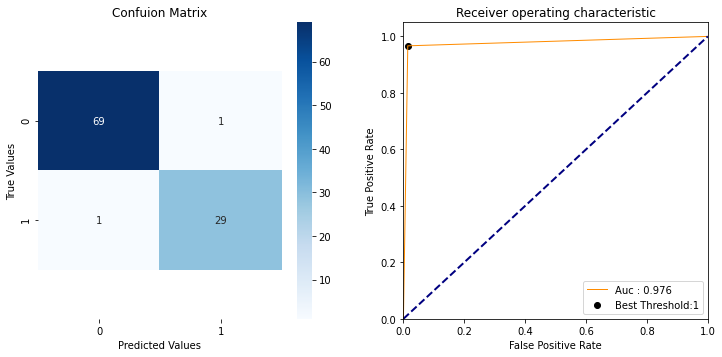

In [28]:
y_pred = model1.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [29]:
confusion_matrix(y_train, model1.predict_classes(x_train))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[10471,   260],
       [  125,  4875]])

Eventhough we get very good results, there is an overfitting which can be seen in the Loss graph. After 25 epochs, the loss of validation set is increasing and loss of training set keeps on decreasing. Also, the accuracy of validation set remains constant after 25 epochs.

#### Model 2

Model 2 is same as Model 1 but the early stopping is implemented to stop overfitting. 

In [30]:
history = History()

model2 = Sequential()
model2.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 7s 23ms/step - loss: 0.2725 - accuracy: 0.8861 - val_loss: 0.4573 - val_accuracy: 0.8780
Epoch 2/100
222/222 [==============================] - 4s 20ms/step - loss: 0.1795 - accuracy: 0.9068 - val_loss: 0.3591 - val_accuracy: 0.8761
Epoch 3/100
222/222 [==============================] - 5s 22ms/step - loss: 0.1380 - accuracy: 0.9165 - val_loss: 0.2882 - val_accuracy: 0.9123
Epoch 4/100
222/222 [==============================] - 5s 21ms/step - loss: 0.1157 - accuracy: 0.9271 - val_loss: 0.2891 - val_accuracy: 0.8964
Epoch 5/100
222/222 [==============================] - 5s 21ms/step - loss: 0.1046 - accuracy: 0.9284 - val_loss: 0.2203 - val_accuracy: 0.9276
Epoch 6/100
222/222 [==============================] - 4s 20ms/step - loss: 0.0896 - accuracy: 0.9399 - val_loss: 0.1993 - val_accuracy: 0.9339
Epoch 7/100
222/222 [==============================] - 4s 19ms/step - loss: 0.0802 - accuracy: 0.9438 - val_loss: 0.1858 - val_accuracy:

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Loss')

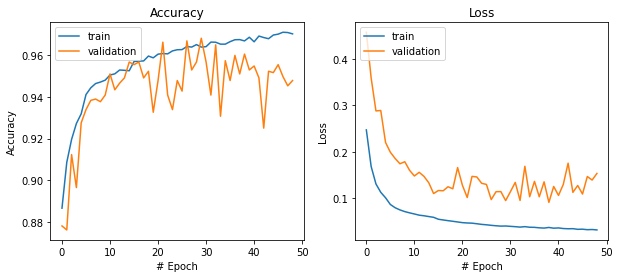

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 Score:  0.923076923076923
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        70
           1       0.86      1.00      0.92        30

    accuracy                           0.95       100
   macro avg       0.93      0.96      0.94       100
weighted avg       0.96      0.95      0.95       100

Area under curve :  0.9642857142857143 



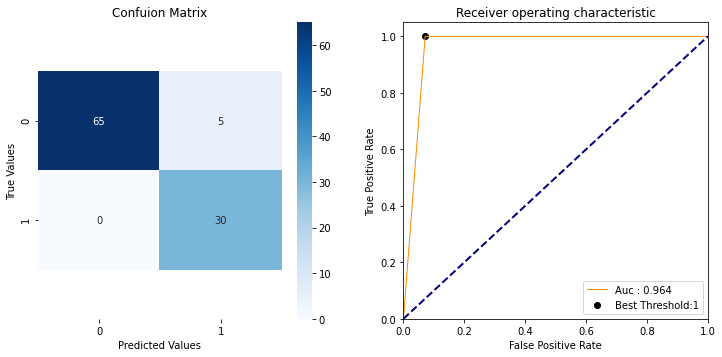

In [37]:
y_pred = model2.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [38]:
confusion_matrix(y_train, model2.predict_classes(x_train))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[10196,   535],
       [   59,  4941]])

#### Model 3

Model 3 is same as Model 2 but dropout is added to further reduce overfitting. 

In [39]:
history = History()

model3 = Sequential()
model3.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model3.add(Dropout(0.25))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time
# fit the model
model3.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 7s 25ms/step - loss: 0.2513 - accuracy: 0.7681 - val_loss: 0.2961 - val_accuracy: 0.8939
Epoch 2/100
222/222 [==============================] - 5s 23ms/step - loss: 0.1434 - accuracy: 0.8818 - val_loss: 0.2636 - val_accuracy: 0.8882
Epoch 3/100
222/222 [==============================] - 5s 23ms/step - loss: 0.1243 - accuracy: 0.8966 - val_loss: 0.2472 - val_accuracy: 0.8875
Epoch 4/100
222/222 [==============================] - 5s 23ms/step - loss: 0.1033 - accuracy: 0.9096 - val_loss: 0.2792 - val_accuracy: 0.8875
Epoch 5/100
222/222 [==============================] - 5s 23ms/step - loss: 0.0956 - accuracy: 0.9199 - val_loss: 0.1873 - val_accuracy: 0.9199
Epoch 6/100
222/222 [==============================] - 5s 24ms/step - loss: 0.0837 - accuracy: 0.9346 - val_loss: 0.1985 - val_accuracy: 0.9225
Epoch 7/100
222/222 [==============================] - 5s 23ms/step - loss: 0.0818 - accuracy: 0.9282 - val_loss: 0.1497 - val_accuracy:

Text(0.5, 1.0, 'Loss')

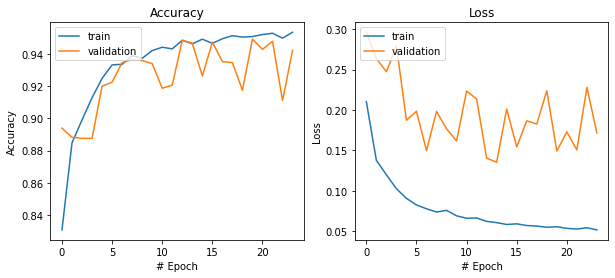

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 Score:  0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.91      1.00      0.95        30

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

Area under curve :  0.9785714285714286 



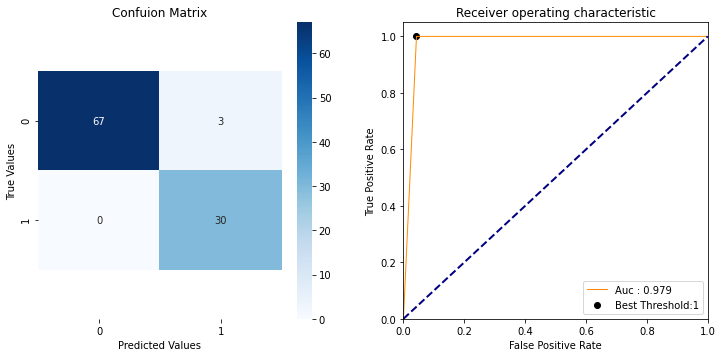

In [42]:
y_pred = model3.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [43]:
confusion_matrix(y_train, model3.predict_classes(x_train))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[10385,   346],
       [  255,  4745]])

#### Model 4

Model 4 has two hidden layers to learn complex patterns in the data.

In [44]:
history = History()

model4 = Sequential()
model4.add(LSTM(
         units=8,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model4.add(Dropout(0.2))
model4.add(LSTM(
         units=4,
         return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 8)             768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [45]:
%%time
# fit the model
model4.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 14s 45ms/step - loss: 0.2386 - accuracy: 0.7826 - val_loss: 0.3023 - val_accuracy: 0.8825
Epoch 2/100
222/222 [==============================] - 9s 41ms/step - loss: 0.1167 - accuracy: 0.9141 - val_loss: 0.2409 - val_accuracy: 0.9149
Epoch 3/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0905 - accuracy: 0.9286 - val_loss: 0.1971 - val_accuracy: 0.9295
Epoch 4/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0808 - accuracy: 0.9398 - val_loss: 0.2330 - val_accuracy: 0.9187
Epoch 5/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0749 - accuracy: 0.9404 - val_loss: 0.1739 - val_accuracy: 0.9333
Epoch 6/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0681 - accuracy: 0.9434 - val_loss: 0.1436 - val_accuracy: 0.9435
Epoch 7/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0602 - accuracy: 0.9484 - val_loss: 0.1943 - val_accurac

Text(0.5, 1.0, 'Loss')

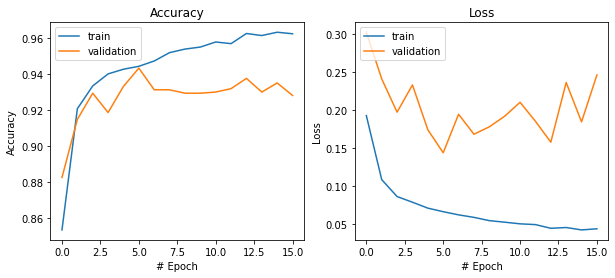

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 Score:  0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.88      1.00      0.94        30

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9714285714285714 



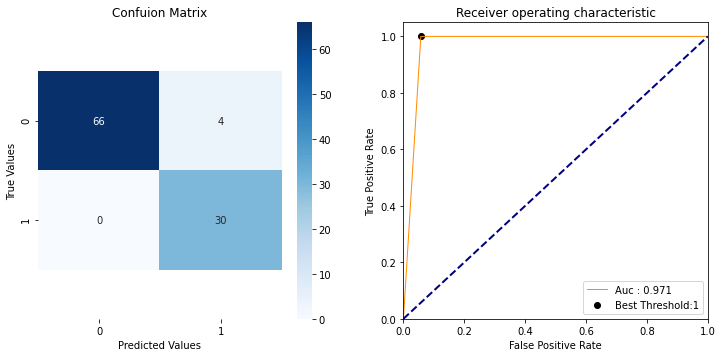

In [47]:
y_pred = model4.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [48]:
confusion_matrix(y_train, model4.predict_classes(x_train))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[9972,  759],
       [  50, 4950]])

#### False Positives Analysis

In [49]:
y_true['pred'] = y_pred
y_true.head()

,RUL,UnitNumber,failure,pred
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0


In [50]:
y_true[y_true.failure != y_true.pred]

,RUL,UnitNumber,failure,pred
61,54,61,0,1
62,72,62,0,1
83,58,83,0,1
92,85,92,0,1


The RUL for False positives is near to 50 cycles only.

### Experiment

LSTM models have stochasticity and the results might be different everytime. I run the model (architecture same as mdoel 4) 10 times and check the performance of model.

In [51]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):
    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn
    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """
    
    score_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 score", "AUC Score"])

    for i in range(0, nruns):
        start = time.time()

        model = Sequential()
        model.add(LSTM(
                 units=8,
                 return_sequences=True,
                 input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(
                  units=4,
                  return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])

        model.fit(X, y, epochs=100, batch_size=64, validation_split = 0.1, verbose=0, class_weight=cls_wt,
              shuffle= True ,callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                  verbose=0, mode='auto')])

        predictions = model.predict_classes(X_test)

        acc = accuracy_score(y_test,predictions)
        pr = precision_score(y_test,predictions)
        rc = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)
        auc = roc_auc_score(y_test,predictions)

        score_df = score_df.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr, 'Recall': rc,
                                    'F1 Score': f1, 'AUC Score': auc}, ignore_index=True)
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")        
    
    return score_df

In [52]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:1 and Runtime:115.689 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:2 and Runtime:174.587 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:3 and Runtime:164.229 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:4 and Runtime:148.743 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:5 and Runtime:154.387 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:6 and Runtime:299.368 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:7 and Runtime:239.405 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:8 and Runtime:178.886 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:9 and Runtime:233.567 Seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Run:10 and Runtime:173.297 Seconds


In [53]:
result_df

,Model,Accuracy,Precision,Recall,F1 score,AUC Score,F1 Score
0,1.0,0.97,0.909091,1.0,NaN,0.978571,0.952381
1,2.0,0.99,0.967742,1.0,NaN,0.992857,0.983607
2,3.0,0.96,0.882353,1.0,NaN,0.971429,0.937500
3,4.0,0.96,0.882353,1.0,NaN,0.971429,0.937500
4,5.0,0.97,0.909091,1.0,NaN,0.978571,0.952381
5,6.0,0.96,0.882353,1.0,NaN,0.971429,0.937500
6,7.0,0.95,0.857143,1.0,NaN,0.964286,0.923077
7,8.0,0.98,0.937500,1.0,NaN,0.985714,0.967742
8,9.0,0.99,0.967742,1.0,NaN,0.992857,0.983607
9,10.0,0.98,0.937500,1.0,NaN,0.985714,0.967742


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Value')

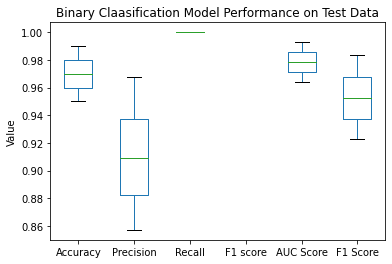

In [54]:
fig, ax = plt.subplots()
result_df.drop(['Model'], axis = 1).boxplot(vert = 1, ax = ax)
ax.set_title('Binary Claasification Model Performance on Test Data')
ax.grid(b=None)
ax.set_ylabel('Value')

In [55]:
result_df.mean()

Model        5.500000
Accuracy     0.971000
Precision    0.913287
Recall       1.000000
F1 score          NaN
AUC Score    0.979286
F1 Score     0.954304
dtype: float64